# Reporte analítica de datos - Proyecto de Grado II

# Modelamiento de los datos

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import datetime as datetime
import sys

In [2]:
data = pd.read_csv('../dengue_data/Data.csv')
df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df['Date'])
df['Age'] = df['Age'].astype(float)
df.set_index('Id', inplace=True)
df.head(10)

,City,Date,Age,Gender,Neighborhood,Commune
Id,,,,,,
1,Buga,2010-01-14,23.0,F,LA MERCED,4
2,Buga,2010-01-11,23.0,F,EL CARMELO,6
3,Buga,2010-01-10,20.0,M,EL CARMELO,6
4,Buga,2010-01-12,6.0,F,SUCRE,3
5,Buga,2010-01-07,13.0,M,POPULAR,5
6,Buga,2010-03-08,20.0,M,DIVINO NINO,3
7,Buga,2010-03-13,18.0,F,DIVINO NINO,3
8,Buga,2010-03-07,36.0,M,ALTO BONITO,1
9,Buga,2010-03-15,40.0,M,EL JARDIN,5


In [23]:
def assign_zeros(nb_df) :
    day_delta = datetime.timedelta(days=1)
    start_date = datetime.date(2010, 1, 1)
    end_date = datetime.date(2020, 1, 1)

    lista = []

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        date2 = date.strftime('%Y-%m-%d')
        try: 
            lista.append(nb_df.at[date2,'Cases'])
        except:  
            lista.append(0)
            
    final_model = pd.DataFrame(columns=('Date', 'Cases'))

    for i in range((end_date - start_date).days):
        date = start_date + i*day_delta
        final_model.loc[len(final_model)]=[date, lista[i]]
        
    return final_model

In [40]:
def calculate_hits(test, predictions) :
    hits = 0
    for i in range(0, len(predictions)) :
        x = test[i]
        y = predictions[i]
        if(x != 0 and y != 0) :
            if(x >= y) :
                hits += y
    return hits

### Técnica de modelado: Autoregresión (AR)

In [25]:
def AR(series, nb_name, max_prediciton_size, optime_lags, period_value, flag, plot) :
    
    if(flag):
        fecha_1 = datetime.date(2016, 12, 31)
        fecha_2 = datetime.date(2017, 1, 1)
    else:
        fecha_1 = datetime.date(2015, 12, 31)
        fecha_2 = datetime.date(2016, 1, 1)

    df_train = series.loc[: fecha_1]
    df_test = series.loc[fecha_2: ]

    y1 = df_train.Cases.to_numpy()
    y2 = df_test.Cases.to_numpy()

    # Entrenamiento del modelo
    train, test = y1, y2

    # train autoregression
    window = optime_lags
    model = AutoReg(train, lags=optime_lags, seasonal=True, period=period_value)
    model_fit = model.fit()
    coef = model_fit.params
    
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(abs(np.round(float(yhat))))
        history.append(obs)
    test = test[-max_prediciton_size:]
    predictions = predictions[0:max_prediciton_size]
    rmse = np.sqrt(mean_squared_error(test, predictions))
    real_cases = sum(i for i in test if i != 0) 
    number_of_predictions = sum(1 for i in predictions if i != 0) 
    hits = calculate_hits(test, predictions)
    if(plot) :
        print('Test RMSE: %.3f' % rmse, '- Hits: ', hits, '- Total predictions:', number_of_predictions,
          '- Real cases:',real_cases, '- LAGS:', optime_lags, '- Days to predict:', max_prediciton_size)
        pyplot.figure(figsize=(25,5))
        pyplot.plot(test)
        pyplot.plot(predictions, color='red')
        pyplot.title(nb_name)  
        pyplot.ylabel("Número de casos") 
        pyplot.xlabel("Días a predecir")
        pyplot.show()
    
    return real_cases, number_of_predictions, rmse, hits



In [78]:
def evaluate_model(neighborhoods_df, city) :
    flag = False
    array_lags = []
    array_days_to_predict = []
    array_rmse = []
    array_hits = []
    array_real_cases = []
    array_number_of_predictions = []
    array_neighborhoods = []
    array_cities = []
    array_period_values = []
    values_for_lags = np.arange(200, 610, 50)
    values_for_days = np.arange(10, 76, 5)
    period_values = np.arange(190, 551, 3)
    for neighborhood_name in neighborhoods_df.index :
        if city == 'Buga' :
            flag = True
            nb_df = dfBuga[dfBuga.Neighborhood == neighborhood_name]
        elif city == 'Giron' :
            nb_df = dfGiron[dfGiron.Neighborhood == neighborhood_name]
        else :
            nb_df = dfYopal[dfYopal.Neighborhood == neighborhood_name]
        nb_df = pd.DataFrame(nb_df['Date'].value_counts().sort_index())
        nb_df.columns = ['Cases']
        nb_df.index.name = 'Date'
        df_zeros = assign_zeros(nb_df)
        df_zeros.set_index('Date',inplace=True) 

        for lags in values_for_lags :
            for days_to_predict in values_for_days :
                for period_value in period_values:
                    real_cases, number_of_predictions, rmse, hits = AR(df_zeros, neighborhood_name, days_to_predict, period_value, lags, flag, False)
                    array_lags.append(lags)
                    array_days_to_predict.append(days_to_predict)
                    array_rmse.append(rmse)
                    array_real_cases.append(real_cases)
                    array_number_of_predictions.append(number_of_predictions)
                    array_neighborhoods.append(neighborhood_name)
                    array_cities.append(city)
                    array_hits.append(hits)
                    array_period_values.append(period_value)
   
    data = {'City': array_cities, 'Neighborhood': array_neighborhoods,
            'Real Cases': array_real_cases, 'Number of predictions': array_number_of_predictions,
            'Lags': array_lags, 'Days to predict': array_days_to_predict, 'Period Value': array_period_values,'RMSE': array_rmse, 'Hits': array_hits}
    
    df_data = pd.DataFrame(data=data)
    return df_data

## ENTRENAMIENTO

### BUGA

In [21]:
dfBuga = df[df.City == 'Buga']

In [8]:
neighborhoods = dfBuga['Neighborhood'].value_counts()
neighborhoods = neighborhoods.to_frame(name='Cases')
neighborhoods = neighborhoods[neighborhoods.Cases >= 177]

In [52]:
evaluate_model(neighborhoods, 'Buga').to_csv('buga_models.csv', index=False)

### GIRÓN

In [7]:
dfGiron = df[df.City == 'Girón']

In [11]:
neighborhoods = dfGiron['Neighborhood'].value_counts()
neighborhoods = neighborhoods.to_frame(name='Cases')
neighborhoods = neighborhoods[neighborhoods.Cases >= 204]

In [ ]:
evaluate_model(neighborhoods, 'Giron').to_csv('giron_models.csv', index=False)

### YOPAL

In [12]:
dfYopal = df[df.City == 'Yopal']

In [13]:
neighborhoods = dfYopal['Neighborhood'].value_counts()
neighborhoods = neighborhoods.to_frame(name='Cases')
neighborhoods = neighborhoods[neighborhoods.Cases >= 193]

In [ ]:
evaluate_model(neighborhoods, 'Yopal').to_csv('yopal_models.csv', index=False)

## SELECCIÓN DEL MEJOR MODELO

In [19]:
def get_predictions(city, neigborhood, days_to_predict, lags, periods) :
    df_neighborhood = None
    flag = False
    if(city == 'Buga') :
        df_neighborhood = dfBuga[dfBuga.Neighborhood == neigborhood]
        flag = True
    elif(city == 'Yopal') :
        df_neighborhood = dfYopal[dfBuga.Neighborhood == neigborhood]
    else :
        df_neighborhood = dfGiron[dfBuga.Neighborhood == neigborhood]
        
    df_neighborhood = pd.DataFrame(df_neighborhood['Date'].value_counts().sort_index())
    df_neighborhood.columns = ['Cases']
    df_neighborhood.index.name = 'Date'
    df_neighborhood = assign_zeros(df_neighborhood)
    df_neighborhood.set_index('Date',inplace=True)
    AR(df_neighborhood, neigborhood, days_to_predict, lags, periods, flag, True)

### BUGA

In [45]:
buga_models = pd.read_csv('models/buga_models.csv', index_col= 0)
df_buga_models = pd.DataFrame(buga_models)
df_buga_models = buga_models.reset_index()

In [79]:
#pd.set_option('display.max_rows', None)
df_buga_models.sort_values(by=['Period Value'], ascending=False).head(1000)

,City,Neighborhood,Real Cases,Number of predictions,Lags,Days to predict,Period Value,RMSE,Hits,Accuracy
81428,Buga,LA HONDA,60,948,550,1060,699,3.676031,8,0.13
75320,Buga,LA HONDA,55,376,450,660,699,1.279204,13,0.24
61842,Buga,LA HONDA,55,194,200,560,699,0.696932,12,0.22
43519,Buga,BALBOA,23,219,250,410,699,0.977802,4,0.17
10448,Buga,FUENMAYOR,60,579,350,1060,699,1.285624,14,0.23
3643,Buga,FUENMAYOR,53,277,250,510,699,0.878948,17,0.32
27641,Buga,SANTA BARBARA,24,633,300,810,699,1.832828,2,0.08
69998,Buga,LA HONDA,56,133,350,760,699,0.553696,3,0.05
38211,Buga,SANTA BARBARA,25,751,500,910,699,2.385856,7,0.28
51789,Buga,BALBOA,23,463,400,560,699,2.552660,17,0.74


In [14]:
def select_best_model(df_model) :
    
    neighborhoods = df_model.Neighborhood.unique()
    
    for nb in neighborhoods :
        df_nb = df_model[df_model.Neighborhood == nb]
        df_nb = df_nb.reset_index()
        first_time = False
        best_result1 = sys.maxsize
        best_result2 = sys.maxsize
        best_result_index = -1
        for i in df_nb.index :
            percentage = abs(df_nb['Hits'][i] / df_nb['Real Cases'][i])
            difference2 = abs(df_nb['Number of predictions'][i] - df_nb['Real Cases'][i])
            
            if(per)
                
        print('BEST MODEL FOR:', nb, "\n", df_nb.iloc[best_result_index], '\nBEST RESULT:', best_result1)


In [15]:
select_best_model(df_buga_models)

BEST MODEL FOR: FUENMAYOR 
 index                        20828
City                          Buga
Neighborhood             FUENMAYOR
Real Cases                      60
Number of predictions         1011
Lags                           550
Days to predict               1060
Period Value                   696
RMSE                       4.90148
Hits                             8
Accuracy                      0.13
Name: 20828, dtype: object 
BEST RESULT: 52
BEST MODEL FOR: SANTA BARBARA 
 index                            40940
City                              Buga
Neighborhood             SANTA BARBARA
Real Cases                          27
Number of predictions              147
Lags                               550
Days to predict                   1060
Period Value                       318
RMSE                          0.416635
Hits                                 1
Accuracy                          0.04
Name: 20110, dtype: object 
BEST RESULT: 26
BEST MODEL FOR: BALBOA 
 index        

#### BARRIO FUENMAYOR

Test RMSE: 0.316 - Hits:  2.0 - Total predictions: 2 - Real cases: 3 - LAGS: 200 - Days to predict: 10


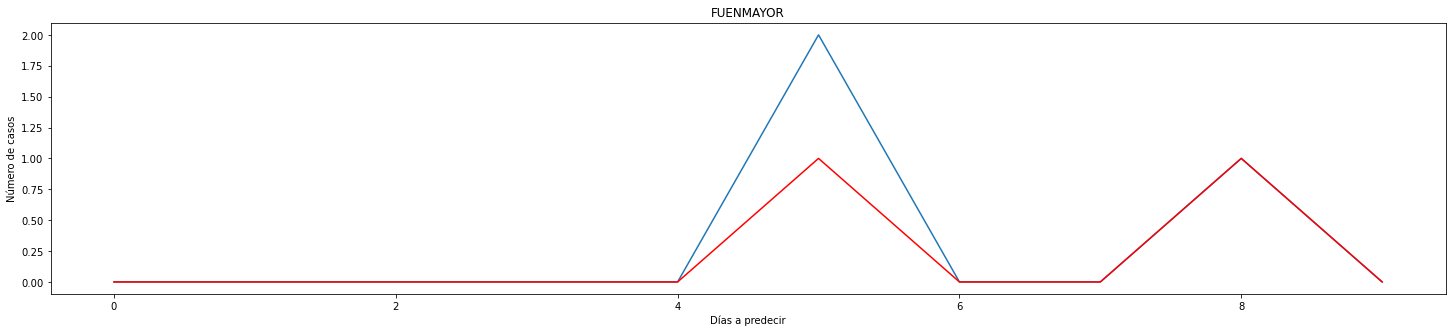

In [41]:
get_predictions('Buga', 'FUENMAYOR', 10, 200, 205)

#### BARRIO SANTA BÁRBARA

Test RMSE: 0.949 - Hits:  0 - Total predictions: 9 - Real cases: 0 - LAGS: 200 - Days to predict: 10


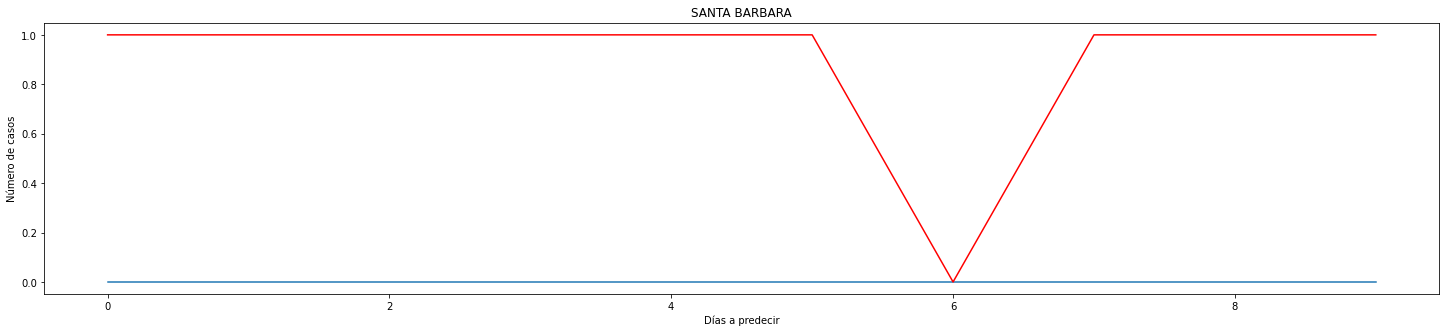

In [51]:
get_predictions('Buga', 'SANTA BARBARA', 10, 200, 205)

#### BARRIO LA HONDA

Test RMSE: 0.548 - Hits:  0 - Total predictions: 2 - Real cases: 1 - LAGS: 200 - Days to predict: 10


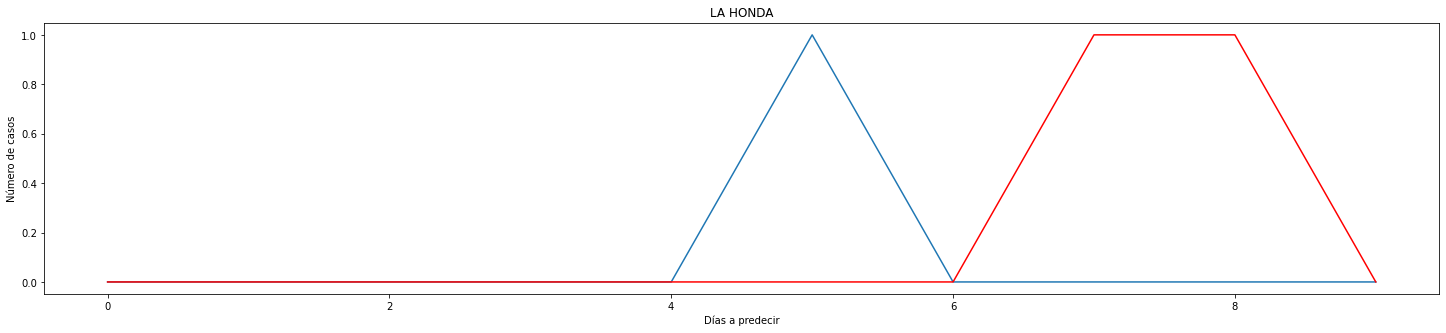

In [52]:
get_predictions('Buga', 'LA HONDA', 10, 200, 205)

#### BARRIO BALBOA

Test RMSE: 1.897 - Hits:  1.0 - Total predictions: 10 - Real cases: 1 - LAGS: 200 - Days to predict: 10


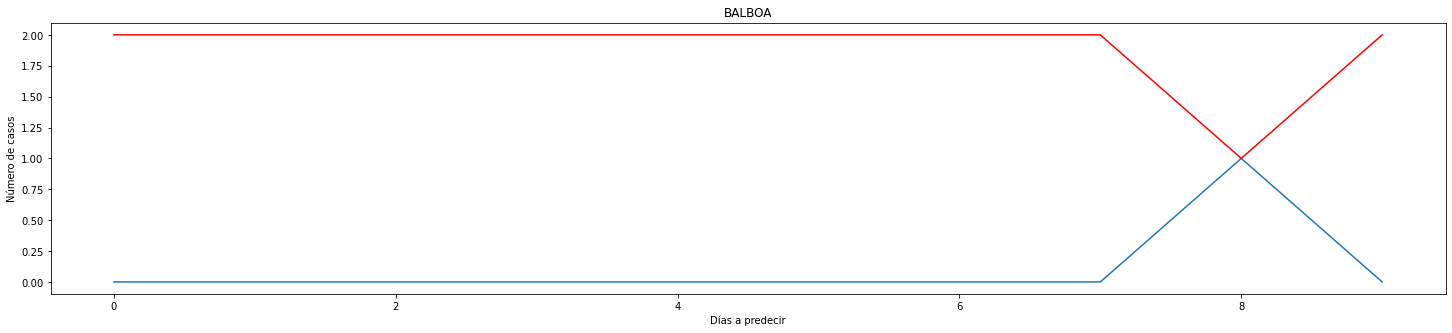

In [59]:
get_predictions('Buga', 'BALBOA', 10, 200, 210)

### YOPAL

In [ ]:
yopal_models = pd.read_csv('models/yopal_models.csv', index_col= 0)
df_yopal_models = pd.DataFrame(yopal_models)

In [ ]:
df_yopal_models.sort_values(by=['Lags', 'Days to predict', 'Hits'], ascending=False)

### GIRÓN

In [ ]:
giron_models = pd.read_csv('models/giron_models.csv', index_col= 0)
df_giron_models = pd.DataFrame(giron_models)

In [ ]:
df_giron_models.sort_values(by=['Lags', 'Days to predict', 'Hits'], ascending=False)